In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Visualizing what convnets learn

[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

----

It is often said that deep learning models are "black boxes", learning representations that are difficult to extract and present in a 
human-readable form. While this is partially true for certain types of deep learning models, it is definitely not true for convnets. The 
representations learned by convnets are highly amenable to visualization, in large part because they are _representations of visual 
concepts_.

Visualizing heatmaps of class activation in an image is useful to understand which part of an image where identified as belonging to a given class, and thus allows to localize objects in images.

We will use the VGG16 model to visualize heatmaps of class activation in an image.

## Visualizing heatmaps of class activation: Class Activation Map

Heatmaps of class activation is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

In [8]:
from keras.applications.vgg16 import VGG16

# Note that we are including the densely-connected classifier on top;
model = VGG16(weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Let's consider the following image of 5 Labrador retriever.
<img src=Labrador_retriever.jpeg>

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according 
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize 
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The local path to our target image
#img_path = './afriacan_elephant.jpg'
#img_path = './Egyptian_cat.jpg'
img_path = './Labrador_retriever.jpeg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch" of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Channel-wise color normalization
x = preprocess_input(x)

In [5]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02099712', 'Labrador_retriever', 0.60521394), ('n02099601', 'golden_retriever', 0.34359834), ('n02104029', 'kuvasz', 0.04729474)]



The top-3 classes predicted for this image are:

* Labrador retriever (with 60.52% probability)
* Golden retriever (with 34.36% probability)
* Kuvasz (with 4.73% probability)

Thus our network has recognized this image as an undetermined quantity of Labrador retriever. The entry in the prediction vector that was maximally activated is the one corresponding to the "Labrador retriever" class, at index 208:

In [7]:
np.argmax(preds[0])

208

To visualize which parts of our image were the most "Labrador retriever"-like, let's set up the Grad-CAM process:

In [9]:
# This is the "maximally activated" entry in the prediction vector
max_output = model.output[:, np.argmax(preds[0])]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the predicted class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(max_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`, given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays, given our sample image
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the predicted class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [10]:
heatmap.shape

(14, 14)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

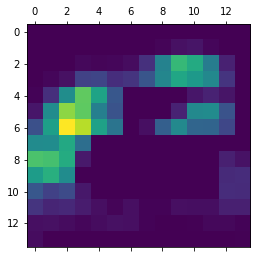

In [11]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
#cv2.imwrite('./African_elephant_cam.jpg', superimposed_img)
#cv2.imwrite('./Labrador_retriever_cam.jpg', superimposed_img)
#cv2.imwrite('./Egyptian_cat_cam.jpg', superimposed_img)

This visualisation technique answers two important questions:

* Why did the network think this image contained an Labrador retriever?
* Where is the Labrador retriever located in the picture?

In particular, it is interesting to note that the ears of the puppy are strongly activated: this is probably how the network can tell the difference between Labrador retriever and Golden retriever.

For more information, please refer to [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).